### Installing Libraries
Below code cell installs the necessary libraries for this notebook, including PyTorch, PyTorch Geometric, ASE, tqdm, mendeleev, e3nn, numpy, and torch_cluster.

In [1]:
!pip install torch torch_geometric torch_scatter ase tqdm mendeleev e3nn numpy torch_cluster

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Importing Neccesary Libraries
Below code cell imports the necessary libraries and modules for this notebook.

In [43]:
# model
# imported for creating and working with neural networks, particularly graph neural networks.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
# used for representing and manipulating crystal structures
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
# imported for numerical operations, plotting, and data manipulation.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d

# utilities
# used for timing, accessing element properties, and displaying progress bars.
import time
from mendeleev import element
from tqdm import tqdm

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]]) #  for visualization

# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

torch device: cpu


Below code cell is a configuration block that standardizes the visual style of Matplotlib plots throughout the notebook by adjusting font sizes, line widths, and tick mark positions.



In [44]:
# standard formatting for plots
fontsize = 16
textsize = 14
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉") #  use in chemical formulas or labels.
plt.rcParams['font.family'] = 'DejaVu Sans' # Specifies the font family to use
plt.rcParams['axes.linewidth'] = 1 #  width of the axes lines to 1 point
plt.rcParams['mathtext.default'] = 'regular' # Configures the default rendering of mathematical text.
# Ensures tick marks are drawn on the bottom and left axes.
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = textsize

Mounting My Drive

In [45]:
import sys
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    Dataset = "/content/drive/My Drive/Dataset"
    path1 = '/content/drive/MyDrive/Dataset/idx_train_240406.txt'
    path2 = '/content/drive/MyDrive/Dataset/idx_valid_240406.txt'
    path3 = '/content/drive/MyDrive/Dataset/idx_test_240406.txt'
    utils_dir_path = '/content/drive/My Drive/utils/utils.py'
    if utils_dir_path not in sys.path:
        sys.path.append(utils_dir_path)
else:
    Dataset = "Dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Opening utils_dir_path

In [46]:
# Add the external folder path to sys.path
sys.path.append("utils_dir_path")
from utils_data import (load_data, plot_example, plot_predictions)
from utils_model import Network, visualize_layers

## Data Visualization

In [47]:
data_df = pd.read_pickle(f"{Dataset}/absorption_mp_data.pkl")
data_df.head()

,id,formula,structure,energies,absorption_coefficient,imag_dielectric,real_dielectric,energy_max,bandgap
0,mp-546266,DyBi2IO4,"(Atom('Dy', [np.float64(0.0), np.float64(0.0),...","[0.0, 0.0277, 0.0554, 0.0831, 0.1109, 0.1386, ...","[0.0, 0.8362304735329499, 3.309178082718349, 7...","[0.0, 0.0015666666666666665, 0.0031, 0.0046666...","[6.9163, 6.916533333333334, 6.9172, 6.9182, 6....",55.4328,1.3818000000000001
1,mp-9583,K2ZnF4,"(Atom('K', [np.float64(1.2531985199117757), np...","[0.0, 0.0399, 0.0798, 0.1197, 0.1596, 0.1995, ...","[0.0, 0.1362578822994739, 0.4541860898852432, ...","[0.0, 0.0001, 0.00016666666666666666, 0.0002, ...","[2.2021333333333333, 2.202166666666667, 2.2022...",79.7804,4.3866
2,mp-22988,CsGeCl3,"(Atom('Cs', [np.float64(7.78333021211009), np....","[0.0, 0.029, 0.058, 0.087, 0.116, 0.1449, 0.17...","[0.0, 0.515935972729374, 2.0145311056971553, 4...","[0.0, 0.0007, 0.0013666666666666669, 0.0020333...","[3.975733333333333, 3.9758333333333336, 3.9761...",57.9759,2.178
3,mp-861502,AcFeO3,"(Atom('Ac', [np.float64(0.0), np.float64(0.0),...","[0.0, 0.0587, 0.1174, 0.176, 0.2347, 0.2934, 0...","[0.0, 11295.053197761259, 44864.495977063896, ...","[0.0, 30.1914, 49.9196, 37.98413333333333, 21....","[67.54320000000001, 59.6215, 29.6067, 1.281, -...",117.3625,0.0
4,mp-1025029,PrHSe,"(Atom('Pr', [np.float64(-2.0265362), np.float6...","[0.0, 0.0365, 0.073, 0.1095, 0.1459, 0.1824, 0...","[0.0, 1.6849892209331498, 6.697792903781345, 1...","[0.0, 0.0026999999999999997, 0.005366666666666...","[8.784633333333334, 8.7851, 8.786566666666667,...",72.9718,1.9455999999999998


## Data Processing
Below code cell extracts and prints the crystal structure data for the first material entry in the DataFrame. This provides a glimpse into the format and content of the structural information used in the notebook.

In [48]:
a_structure = data_df.iloc[0]["structure"]
print(a_structure)

Atoms(symbols='DyBi2IO4', pbc=True, cell=[3.945744, 3.945744, 9.707467])


In [49]:
structure = data_df.iloc[0]["structure"]
print(structure)

Atoms(symbols='DyBi2IO4', pbc=True, cell=[3.945744, 3.945744, 9.707467])


In [50]:
formula = data_df.iloc[0]["formula"]
print(formula)

DyBi2IO4


In [51]:
symbols = data_df.iloc[0]["structure"].symbols
print(symbols)

DyBi2IO4


In [52]:
symbols = data_df.iloc[0]["structure"].symbols
print(symbols)

DyBi2IO4


In [53]:
positions = data_df.iloc[0]["structure"].positions
print(positions)

[[0.         0.         0.        ]
 [1.972872   1.972872   2.49053803]
 [1.972872   1.972872   7.21692897]
 [0.         0.         4.8537335 ]
 [1.972872   0.         8.32744378]
 [0.         1.972872   8.32744378]
 [1.972872   0.         1.38002322]
 [0.         1.972872   1.38002322]]


### Properties of Elements
A lookup table for obtaining specific physical and chemical properties of different elements based on their symbols. Each entry in the dictionary uses the element's symbol as the key and a list containing its atomic number index, atomic mass, dipole polarizability, and atomic radius as the value

In [54]:
# ElementSymbol: [AtomicNumberIndex, AtomicMass, DipolePolarizability, AtomicRadius]

idx_mass_dip_rad = {'H': [0, 1.008, 32.0, 4.50711], 'He': [1, 4.002602, 46.0, 1.38375], 'Li': [2, 6.94, 133.0, 164.1125],
                    'Be': [3, 9.0121831, 102.0, 37.74], 'B': [4, 10.81, 85.0, 20.5], 'C': [5, 12.011, 75.0, 11.3],
                    'N': [6, 14.007, 71.0, 7.4], 'O': [7, 15.999, 63.0, 5.3], 'F': [8, 18.998403163, 64.0, 3.74],
                    'Ne': [9, 20.1797, 67.0, 2.6611], 'Na': [10, 22.98976928, 155.0, 162.7], 'Mg': [11, 24.305, 139.0, 71.2],
                    'Al': [12, 26.9815385, 126.0, 57.8], 'Si': [13, 28.085, 115.99999999999999, 37.3], 'P': [14, 30.973761998, 111.00000000000001, 25.0],
                    'S': [15, 32.06, 103.0, 19.4], 'Cl': [16, 35.45, 99.0, 14.6], 'Ar': [17, 39.948, 96.0, 11.083],
                    'K': [18, 39.0983, 196.0, 289.7], 'Ca': [19, 40.078, 171.0, 160.8], 'Sc': [20, 44.955908, 148.0, 97.0],
                    'Ti': [21, 47.867, 136.0, 100.0], 'V': [22, 50.9415, 134.0, 87.0], 'Cr': [23, 51.9961, 122.0, 83.0],
                    'Mn': [24, 54.938044, 119.0, 68.0], 'Fe': [25, 55.845, 115.99999999999999, 62.0], 'Co': [26, 58.933194, 111.00000000000001, 55.0],
                    'Ni': [27, 58.6934, 110.00000000000001, 49.0], 'Cu': [28, 63.546, 112.00000000000001, 46.5], 'Zn': [29, 65.38, 118.0, 38.67],
                    'Ga': [30, 69.723, 124.0, 50.0], 'Ge': [31, 72.63, 121.0, 40.0], 'As': [32, 74.921595, 121.0, 30.0],
                    'Se': [33, 78.971, 115.99999999999999, 28.9], 'Br': [34, 79.904, 113.99999999999999, 21.0], 'Kr': [35, 83.798, 117.0, 16.78],
                    'Rb': [36, 85.4678, 210.0, 319.8], 'Sr': [37, 87.62, 185.0, 197.2], 'Y': [38, 88.90584, 163.0, 162.0],
                    'Zr': [39, 91.224, 154.0, 112.0], 'Nb': [40, 92.90637, 147.0, 98.0], 'Mo': [41, 95.95, 138.0, 87.0],
                    'Tc': [42, 97.90721, 128.0, 79.0], 'Ru': [43, 101.07, 125.0, 72.0], 'Rh': [44, 102.9055, 125.0, 66.0],
                    'Pd': [45, 106.42, 120.0, 26.14], 'Ag': [46, 107.8682, 128.0, 55.0], 'Cd': [47, 112.414, 136.0, 46.0],
                    'In': [48, 114.818, 142.0, 65.0], 'Sn': [49, 118.71, 140.0, 53.0], 'Sb': [50, 121.76, 140.0, 43.0],
                    'Te': [51, 127.6, 136.0, 38.0], 'I': [52, 126.90447, 133.0, 32.9], 'Xe': [53, 131.293, 131.0, 27.32],
                    'Cs': [54, 132.90545196, 231.99999999999997, 400.9], 'Ba': [55, 137.327, 196.0, 272.0], 'La': [56, 138.90547, 180.0, 215.0],
                    'Ce': [57, 140.116, 163.0, 205.0], 'Pr': [58, 140.90766, 176.0, 216.0], 'Nd': [59, 144.242, 174.0, 208.0],
                    'Pm': [60, 144.91276, 173.0, 200.0], 'Sm': [61, 150.36, 172.0, 192.0], 'Eu': [62, 151.964, 168.0, 184.0],
                    'Gd': [63, 157.25, 169.0, 158.0], 'Tb': [64, 158.92535, 168.0, 170.0], 'Dy': [65, 162.5, 167.0, 163.0],
                    'Ho': [66, 164.93033, 166.0, 156.0], 'Er': [67, 167.259, 165.0, 150.0], 'Tm': [68, 168.93422, 164.0, 144.0],
                    'Yb': [69, 173.045, 170.0, 139.0], 'Lu': [70, 174.9668, 162.0, 137.0], 'Hf': [71, 178.49, 152.0, 103.0],
                    'Ta': [72, 180.94788, 146.0, 74.0], 'W': [73, 183.84, 137.0, 68.0], 'Re': [74, 186.207, 131.0, 62.0],
                    'Os': [75, 190.23, 129.0, 57.0], 'Ir': [76, 192.217, 122.0, 54.0], 'Pt': [77, 195.084, 123.0, 48.0],
                    'Au': [78, 196.966569, 124.0, 36.0], 'Hg': [79, 200.592, 133.0, 33.91], 'Tl': [80, 204.38, 144.0, 50.0],
                    'Pb': [81, 207.2, 144.0, 47.0], 'Bi': [82, 208.9804, 151.0, 48.0], 'Po': [83, 209.0, 145.0, 44.0],
                    'At': [84, 210.0, 147.0, 42.0], 'Rn': [85, 222.0, 142.0, 35.0], 'Fr': [86, 223.0, 223.0, 317.8],
                    'Ra': [87, 226.0, 200.99999999999997, 246.0], 'Ac': [88, 227.0, 186.0, 203.0], 'Th': [89, 232.0377, 175.0, 217.0],
                    'Pa': [90, 231.03588, 169.0, 154.0], 'U': [91, 238.02891, 170.0, 129.0], 'Np': [92, 237.0, 171.0, 151.0],
                    'Pu': [93, 244.0, 172.0, 132.0], 'Am': [94, 243.0, 166.0, 131.0], 'Cm': [95, 247.0, 166.0, 144.0],
                    'Bk': [96, 247.0, 168.0, 125.0], 'Cf': [97, 251.0, 168.0, 122.0], 'Es': [98, 252.0, 165.0, 118.0],
                    'Fm': [99, 257.0, 167.0, 113.0], 'Md': [100, 258.0, 173.0, 109.0], 'No': [101, 259.0, 176.0, 110.0],
                    'Lr': [102, 262.0, 161.0, 320.0], 'Rf': [103, 267.0, 157.0, 112.0], 'Db': [104, 268.0, 149.0, 42.0],
                    'Sg': [105, 271.0, 143.0, 40.0], 'Bh': [106, 274.0, 141.0, 38.0], 'Hs': [107, 269.0, 134.0, 36.0],
                    'Mt': [108, 276.0, 129.0, 34.0], 'Ds': [109, 281.0, 128.0, 32.0], 'Rg': [110, 281.0, 121.0, 32.0],
                    'Cn': [111, 285.0, 122.0, 28.0], 'Nh': [112, 286.0, 136.0, 29.0], 'Fl': [113, 289.0, 143.0, 31.0],
                    'Mc': [114, 288.0, 162.0, 71.0], 'Lv': [115, 293.0, 175.0, 0.0], 'Ts': [116, 294.0, 165.0, 76.0],
                    'Og': [117, 294.0, 157.0, 58.0]}

### Data Structures
This cell provides both a visual representation of a sample crystal structure and a statistical overview of the lattice parameters within the dataset.

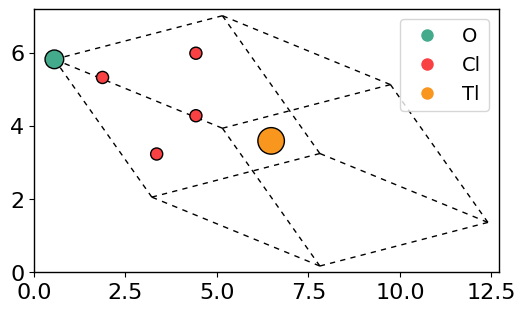

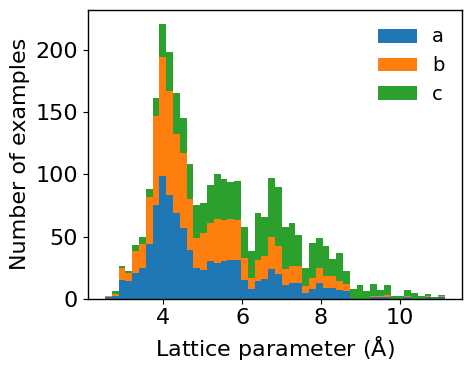

In [55]:
# plot an example structure
i = 16 # structure index in dataframe
struct = data_df.iloc[i]['structure']
symbols = np.unique(list(struct.symbols))
z = dict(zip(symbols, range(len(symbols))))

# Create the plot
fig, ax = plt.subplots(figsize=(6,6))
norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('45x,45y,0z'))

# Add legend with atom labels
legend_elements = []
for symbol, color in zip(set(symbols), [cmap(norm(i)) for i in range(len(set(symbols)))]):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=symbol, markerfacecolor=color, markersize=10))
ax.legend(handles=legend_elements, loc='upper right')

# lattice parameter statistics
def get_lattice_parameters(data):
    a = []
    len_data = len(data)
    for i in range(len_data):
        d = data.iloc[i]
        a.append(d.structure.cell.cellpar()[:3])
    return np.stack(a)
a = get_lattice_parameters(data_df)

fig, ax = plt.subplots(figsize=(5,4))
b = 0.
bins = 50
for d, c, n in zip(['a', 'b', 'c'], colors.values(), [a[:,0], a[:,1], a[:,2]]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('Lattice parameter ($\AA$)')
ax.set_ylabel('Number of examples')
ax.legend(frameon=False)
plt.tight_layout()
#fig.savefig('data-lattice.pdf')
#print('average lattice parameter (a/b/c):', a[:,0].mean(), '/', a[:,1].mean(), '/', a[:,2].mean())

# Show the plot
plt.show()

### Nodes
This function takes a crystal structure and extracts specific properties for each atom, organizing them into lists. The approach of creating 118-element arrays for each property seems intended for some form of encoding or feature representation, although the way working_nodes is constructed might need adjustment depending on its intended use.



In [56]:
def art_nodes(struct):
    # The article nodes
    the_z = []
    the_masses = []
    the_dipole = []
    the_radius = []

    # Your working nodes
    working_nodes = []


    the_atoms = list(struct.symbols)

    for i in the_atoms:
        symb = i
        the_index = idx_mass_dip_rad[symb][0]

        # The Z
        x_z = np.zeros(118)
        x_z[the_index] = the_index + 1
        the_z.append(x_z)

        # The masses
        x_mass = np.zeros(118)
        x_mass[the_index] = idx_mass_dip_rad[symb][1]
        the_masses.append(x_mass)

        # The dipole of polarizability
        x_dipole = np.zeros(118)
        x_dipole[the_index] = idx_mass_dip_rad[symb][2]
        the_dipole.append(x_dipole)

        # The covalent radius
        x_radius = np.zeros(118)
        x_radius[the_index] = idx_mass_dip_rad[symb][3]
        the_radius.append(x_radius)

        your_node = np.array([the_index+1, idx_mass_dip_rad[symb][1], idx_mass_dip_rad[symb][2], idx_mass_dip_rad[symb][3]])
        np.append(working_nodes, your_node)
    return the_z, the_masses, the_dipole, the_radius, working_nodes

#print(art_nodes(data_df.iloc[0]["structure"]))

### Reconstructing Data
Below code standardizes the energy points for the absorption and dielectric data across all entries in the DataFrame by interpolating the existing data onto a new, fixed energy grid.



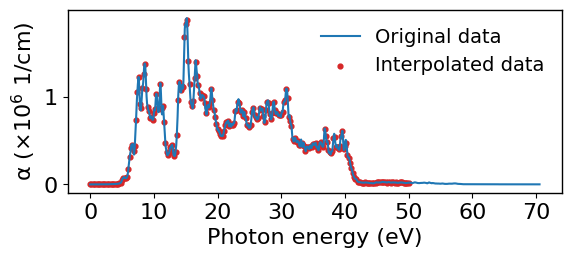

In [57]:
# define the range and number of points for the new energy axis
energy_min = 0.0 #Unit of energy in eV
energy_max = 50.0 #Unit of energy in eV
nstep = 251 #Number of the energy points

# Create New Energy Axis
new_x = np.linspace(energy_min, energy_max, nstep)
def interpolate(row, column):
  # fill_value=0 and bounds_error=False handle cases where the new energy points are outside the range of the original energies
    interp = interp1d(row['energies'], row[column], kind='linear', fill_value=0, bounds_error=False) # create a linear interpolation function based on the original energies and the specified column data for that row
    new_y = interp(new_x)
    return new_y

# Apply the custom function to create a new column
data_df['energies_interp'] = data_df.apply(lambda x: new_x, axis=1)
data_df['imag_dielectric_interp'] = data_df.apply(lambda row: interpolate(row, 'imag_dielectric'), axis=1)
data_df['real_dielectric_interp'] = data_df.apply(lambda row: interpolate(row, 'real_dielectric'), axis=1)
data_df['absorption_coefficient_interp'] = data_df.apply(lambda row: interpolate(row, 'absorption_coefficient'), axis=1)


# Show the plot for compare the original data and interpolated data
plt.figure(figsize=(6, 7))

plt.subplot(3, 1, 3)
plt.plot(data_df['energies'][i], data_df['absorption_coefficient'][i]/1.0E6, label='Original data')
plt.scatter(data_df['energies_interp'][i], data_df['absorption_coefficient_interp'][i]/1.0E6, s=12, marker ='o', alpha=1, color='C3', label='Interpolated data')
x_ticks = np.arange(0, 80, 10)
plt.xticks(x_ticks)
plt.xlabel('Photon energy (eV)')
plt.ylabel(r'$\alpha$ ($\times 10^6$ 1/cm)')
plt.legend(frameon=False)


plt.tight_layout()
#plt.savefig('data-interpolation.pdf')
plt.show()

### Node Features

In [58]:
# one-hot encoding atom type
type_encoding = {} # map element symbols to a numerical index
specie_mass = [] # store the mass for each element
specie_dipole = [] # dipole polarizability for each element
specie_radius = [] # covalent radius for each element
for Z in tqdm(range(1, 119), bar_format=bar_format):              # number of elements
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    Z_mass = specie.mass                                           # Atomic Mass (amu)
    Z_dipole = element(specie.symbol).dipole_polarizability        # Dipole Polarizability (a0^3)
    if Z_dipole == None:
        Z_dipole = 67.0
    Z_radius = element(specie.symbol).covalent_radius_pyykko       # Covalent radius by Bragg (pm)
    specie_mass.append(Z_mass)
    specie_dipole.append(Z_dipole)
    specie_radius.append(Z_radius)

type_onehot = torch.eye(len(type_encoding)) # identity matrix where the size is the number of elements found.
mass_onehot = torch.diag(torch.tensor(specie_mass)) # diagonal matrix where the diagonal elements are the atomic masses.
dipole_onehot = torch.diag(torch.tensor(specie_dipole)) # diagonal matrix where the diagonal elements are the dipole polarizabilities.
radius_onehot = torch.diag(torch.tensor(specie_radius)) # diagonal matrix where the diagonal elements are the covalent radii.
#print(mass_onehot)

100%|██████████| 118/118 [02:05<00:00,  1.07s/it]


### Graph Representation
Below cell transforms the raw crystal structure and property data into a list of torch_geometric.data.Data objects, where each object represents a material as a graph with nodes (atoms) and edges (connections between neighboring atoms), along with associated features and the target property.

In [73]:
# Find the scale value
tmp = np.array([data_df.iloc[i]['absorption_coefficient'] for i in range(len(data_df))])
# scale_data = np.median(np.max(tmp, axis=1))
# print(scale_data)

# build data
'''these two lines allow you to easily add visual progress indicators to
your pandas data processing operations, which is helpful for monitoring
the progress of potentially long-running tasks.'''
from tqdm.auto import tqdm
tqdm.pandas()

def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)

    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)

    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x_mass=mass_onehot[[type_encoding[specie] for specie in symbols]],       # atomic mass (node feature)
        x_dipole=dipole_onehot[[type_encoding[specie] for specie in symbols]],   # atomic dipole polarizability (node feature)
        x_radius=radius_onehot[[type_encoding[specie] for specie in symbols]],   # atomic covalent radius (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]],            # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        y=torch.from_numpy(entry.absorption_coefficient_interp/scale_data).unsqueeze(0)
    )

    return data

r_max = 6. # cutoff radius
data_df['data'] = data_df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)
print(data_df['data'][3])

  0%|          | 0/940 [00:00<?, ?it/s]

Data(edge_index=[2, 375], y=[1, 251], pos=[5, 3], lattice=[1, 3, 3], symbol=[5], x_mass=[5, 118], x_dipole=[5, 118], x_radius=[5, 118], z=[5, 118], edge_shift=[375, 3], edge_vec=[375, 3], edge_len=[375])


### Splitting and Build DataLoader

In [74]:
from sklearn.model_selection import train_test_split
run_time = 240406
# load train/valid/test indices
with open(path1, 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open(path2, 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open(path3, 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

# format dataloaders
batch_size = 1 #  batch processed by the model will contain a single graph
dataloader_train = tg.loader.DataLoader(data_df.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(data_df.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(data_df.iloc[idx_test]['data'].values, batch_size=batch_size)

### Interatomic Distances
Below cell calculates the number of neighbors for each atom in the dataset splits and visualizes the distribution of these neighbor counts using histograms. It also provides the average number of neighbors for each set. This analysis is useful for understanding the connectivity and density of the crystal structures in the dataset, which is relevant for the performance of the graph neural network model.



average number of neighbors (train/valid/test): 51.03625673689368 / 53.70992366412214 / 47.90437601296596


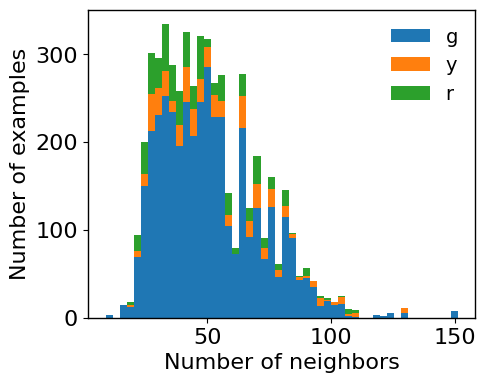

In [75]:
# calculate average number of neighbors
def get_neighbors(data_df, idx):
    n = []
    for entry in data_df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(data_df, idx_train)
n_valid = get_neighbors(data_df, idx_valid)
n_test = get_neighbors(data_df, idx_test)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0. # keep track of the bottom position for stacking the histograms
bins = 50 # sets the number of bins for the histograms to 50
for (d, c), n in zip(colors.items(), [n_train, n_valid, n_test]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('Number of neighbors')
ax.set_ylabel('Number of examples')
ax.legend(frameon=False)

print('average number of neighbors (train/valid/test):', n_train.mean(), '/', n_valid.mean(), '/', n_test.mean())

### Periodic Graph Neural Model
Below code cell defines and initializes the PeriodicNetwork model, a type of Graph Neural Network specifically designed to process crystal structures by respecting their periodic nature and symmetries. The model is configured with parameters that determine its architecture, including the input and output dimensions, the number of layers, and the properties of the spherical harmonics used for capturing spatial information.

In [76]:
class MixingLinear(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(MixingLinear, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(self.out_feature, self.in_feature))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5**0.5)

    def forward(self, x):
        weight = torch.abs(self.weight)/(torch.sum(torch.abs(self.weight), dim=1, keepdim=True)+1e-10)
        return F.linear(x, weight)

In [77]:
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs): # Defines the constructor for the PeriodicNetwork class.
        # override the `reduce_output` keyword to instead perform an averge over atom contributions
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True

        super().__init__(**kwargs)

        # embed the one-hot encoding
        self.em_type = nn.Linear(in_dim, em_dim)    #Linear layer for atom type
        self.em_mass = nn.Linear(in_dim, em_dim)    #Linear layer for atom mass
        self.em_dipole = nn.Linear(in_dim, em_dim)  #Linear layer for atom dipole polarizability
        self.em_radius = nn.Linear(in_dim, em_dim)  #Linear layer for atom covalent radius
        self.em_mixing = MixingLinear(3, 1)         #Linear layer for mixing the atom features (mass, dipole, radius)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_type(data.z))
        data.x_mass = F.relu(self.em_mass(data.x_mass))
        data.x_dipole = F.relu(self.em_dipole(data.x_dipole))
        data.x_radius = F.relu(self.em_radius(data.x_radius))
        tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius], dim=0)      # stack the atom features in shape (3, N, em_dim)
        tmp2 = torch.permute(tmp, (1, 2, 0))                                       # permute the tensor to (N, em_dim, 3)
        data.x = torch.permute(self.em_mixing(tmp2),(2, 0, 1)).reshape(-1, em_dim) # reshape the tensor to (N, em_dim)
        output = super().forward(data)
        # ReLu for last convolution will force output positive value, if output have negative value, it step should be neglected
        output = torch.relu(output)

        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example

        # normalization output from 0 to 1
        #maxima, _ = torch.max(output, dim=1)
        #output = output.div(maxima.unsqueeze(1))

        return output

## Below cell initializes the PeriodicNetwork model, a type of Graph Neural Network designed for crystal structures.

In [78]:
out_dim = len(data_df.iloc[0]['energies_interp'])      # about 200 points
em_dim = 64

model = PeriodicNetwork(
    in_dim=118,                            # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    irreps_in=str(em_dim)+"x0e",           # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e",         # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim)+"x0e",    # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=2,                              # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,                                # multiplicity of irreducible representations
    lmax=2,                                # maximum order of spherical harmonics
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

print(model)
# visualize tensor products of the model
# visualize_layers(model)

PeriodicNetwork(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(64x0e x 64x0e -> 96x0e+32x1o+32x2e | 393216 paths | 393216 weights)
        (lin1): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e | 262144 paths | 262144 weights)
        (fc): FullyConnectedNet[10, 100, 192]
        (tp): TensorProduct(64x0e x 1x0e+1x1o+1x2e -> 64x0e+64x1o+64x2e | 192 paths | 192 weights)
        (lin2): FullyConnectedTensorProduct(64x0e+64x1o+64x2e x 64x0e -> 96x0e+32x1o+32x2e | 655360 paths | 655360 weights)
      )
      (second): Gate (96x0e+32x1o+32x2e -> 32x0e+32x1o+32x2e)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o+32x2e x 64x0e -> 160x0e+32x1o+32x1e+32x2o+32x2e | 458752 paths | 458752 weights)
        (lin1): FullyConnectedTensorProduct(32x0e+32x1o+32x2e x 64x0e -> 32x0e+32x1o+32x2e | 196608 paths | 196608 weights)
        (fc): FullyConnectedNet[10, 100, 

### Setting up Training
The code cell below sets up the optimizer, learning rate scheduler, and loss functions that will be used to train the neural network model. It initializes the AdamW optimizer for updating model weights, an exponential learning rate scheduler to adjust the learning rate during training, and Mean Squared Error (MSE) and Mean Absolute Error (MAE) loss functions to evaluate the model's performance.

In [79]:
opt = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

#loss_fn = torch.nn.HuberLoss()
loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

run_name = 'model_alpha_' + str(run_time)
model.pool = True
# train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name,
#        max_iter=100, scheduler=scheduler, device=device)

## Visualize the Model's Performance
The code cell below loads the training history of the model and plots the training and validation loss over epochs. This visualization helps in understanding the model's learning process and identifying potential issues like overfitting.

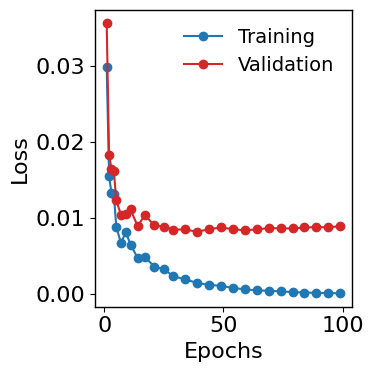

In [80]:
# Set a default font that is available in Colab to suppress warnings
plt.rcParams['font.family'] = 'DejaVu Sans'

# load pre-trained model and plot its training history
#run_name = 'model_alpha_mass_' + run_time
history = torch.load('/content/drive/My Drive/model/' + run_name + '.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

np.savetxt(run_name+'_MSE_loss.txt', np.column_stack((steps, loss_train, loss_valid)), fmt='%.8f', delimiter='\t')

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(steps, loss_train, 'o-', label="Training", color='C0')
ax.plot(steps, loss_valid, 'o-', label="Validation", color='C3')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
plt.tight_layout()
fig.savefig(run_name + '_loss.pdf')

### Model Prediction

In [123]:
# predict on all data
model.load_state_dict(torch.load('/content/drive/My Drive/model/'+run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(data_df['data'].values, batch_size=64)
data_df['mse'] = 0.
data_df['y_pred'] = np.empty((len(data_df), 0)).tolist()

model.to(device)
model.eval()

# weight contribution of each feature
weight = torch.abs(model.em_mixing.weight)/(torch.sum(torch.abs(model.em_mixing.weight), dim=1, keepdim=True)+1e-10)
print(weight)

with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.y, reduction='none').mean(dim=-1).cpu().numpy()
        data_df.loc[i0:i0 + len(d.y) - 1, 'y_pred'] = [[k] for k in output.cpu().numpy()]
        data_df.loc[i0:i0 + len(d.y) - 1, 'mse'] = loss
        i0 += len(d.y)

data_df['y_pred'] = data_df['y_pred'].map(lambda x: x[0])
print(data_df['y_pred'][3])

tensor([[1.0683e-04, 8.3295e-04, 9.9906e-01]], grad_fn=<DivBackward0>)


  0%|          | 0/15 [00:00<?, ?it/s]

[0.         0.         0.         0.         0.         0.
 0.         0.05985724 0.05404472 0.         0.0301039  0.02132694
 0.00907561 0.01618862 0.0353105  0.07529551 0.11670144 0.15336239
 0.16453257 0.13950631 0.09959817 0.08908195 0.08153055 0.06935657
 0.07682267 0.07092126 0.0760803  0.09385351 0.11244328 0.14384577
 0.16184884 0.19742888 0.26140822 0.30779    0.26347486 0.32352412
 0.37087123 0.36813886 0.46757832 0.49159214 0.48568624 0.50702901
 0.52858501 0.52329887 0.53942865 0.56202956 0.5788063  0.62778414
 0.65979395 0.65336425 0.68012985 0.68215498 0.64888249 0.67322935
 0.66820294 0.64309148 0.64183818 0.67293769 0.65146959 0.62761825
 0.59303565 0.56108144 0.54737706 0.51350073 0.48237647 0.45075187
 0.41340502 0.41105265 0.38424689 0.27208387 0.22436557 0.22353378
 0.2896147  0.32117434 0.32044474 0.30128043 0.30192336 0.29190471
 0.28020123 0.30221887 0.3152818  0.34753117 0.43030593 0.50080736
 0.51181702 0.5622217  0.52564659 0.56918241 0.56294182 0.47867365
 0.

Material Index: 410, Formula: BiClO


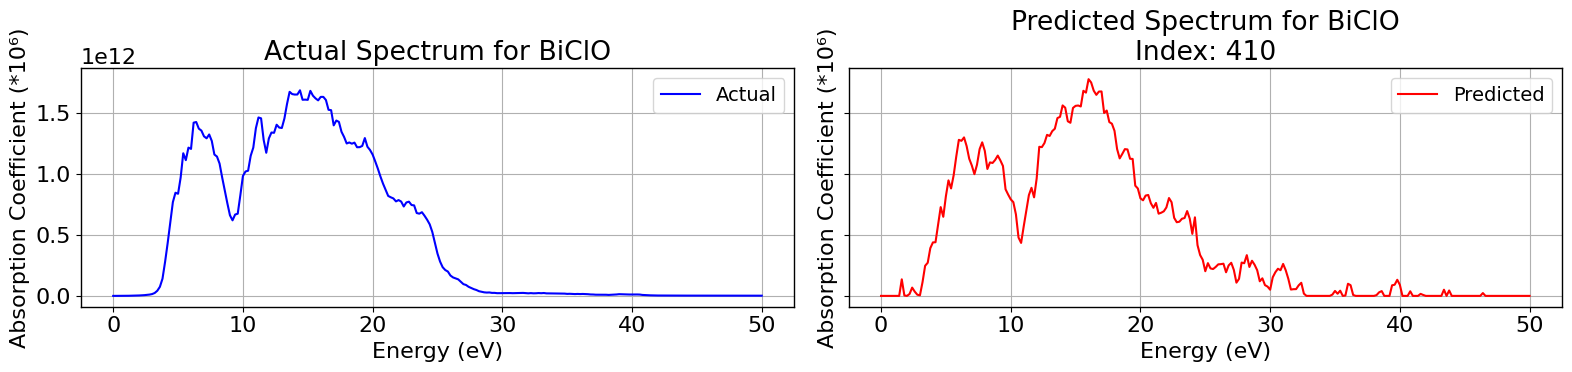

In [82]:
idx = idx_test[100]  # or idx_test[5], or random.choice(idx_test)

# Get the formula and translate if needed
material_formula = data_df.iloc[idx]['formula'].translate(sub)
print(f"Material Index: {idx}, Formula: {material_formula}")

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# Plot Actual Spectrum
axes[0].plot(
    data_df['energies_interp'][idx],
    data_df['absorption_coefficient_interp'][idx] * 1e6,
    color='blue',
    label='Actual'
)
axes[0].set_xlabel('Energy (eV)')
axes[0].set_ylabel('Absorption Coefficient (*10⁶)')
axes[0].set_title(f'Actual Spectrum for {material_formula}')
axes[0].grid(True)
axes[0].legend()

# Plot Predicted Spectrum
axes[1].plot(
    data_df['energies_interp'][idx],
    data_df['y_pred'][idx] * 1e6,
    color='red',
    label='Predicted'
)
axes[1].set_xlabel('Energy (eV)')
axes[1].set_ylabel('Absorption Coefficient (*10⁶)')
axes[1].set_title(f'Predicted Spectrum for {material_formula}\nIndex: {idx}')
axes[1].grid(True)
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## Visualizing Predictions on Test Set
The code cell below visualizes the actual and predicted absorption spectra for a selection of materials from the test set. It generates a grid of plots, where each row displays the actual and predicted spectrum for a different material. This allows for a visual comparison of the model's performance on various examples and helps to understand how well the model captures the shape and features of the absorption spectra.

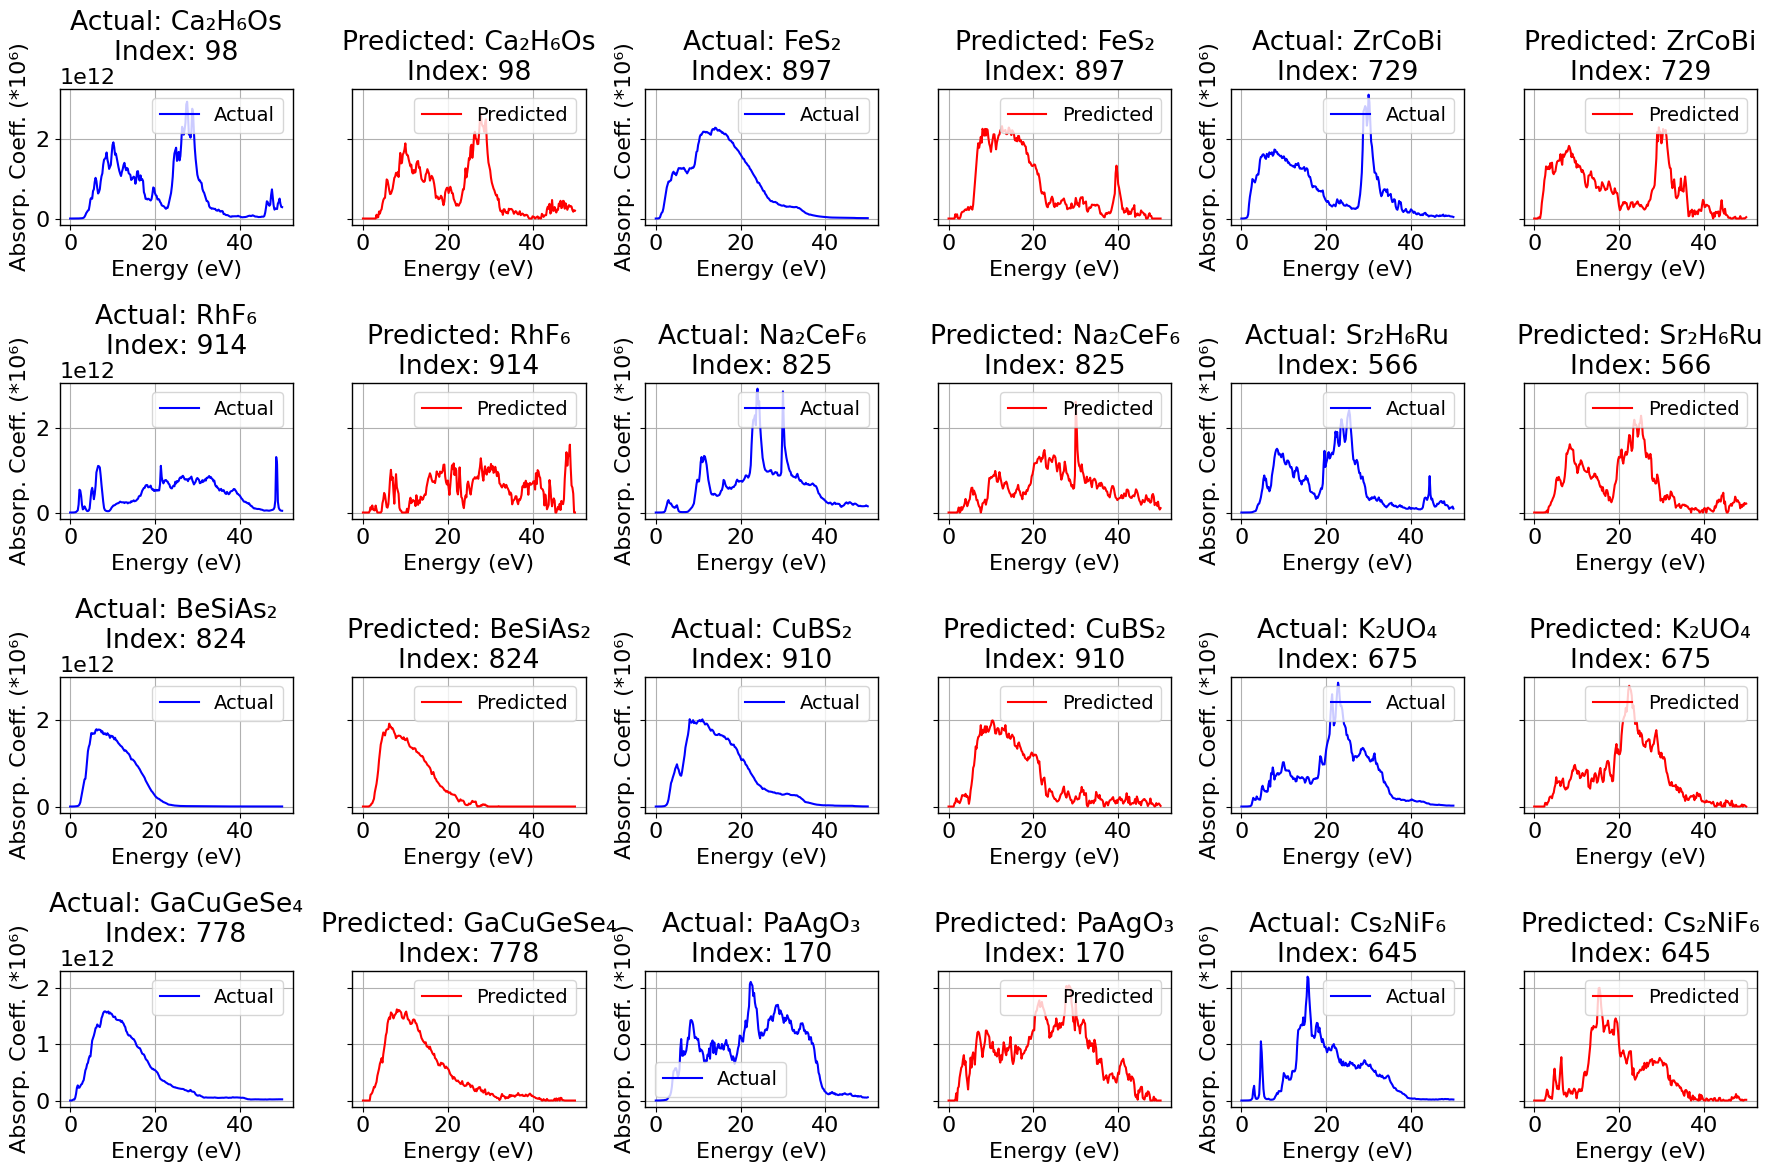

In [83]:
selected_indices = idx_test[:12]

fig, axes = plt.subplots(4, 3 * 2, figsize=(18, 12), sharey='row')  # 3 pairs of plots per row, 4 rows

# Flatten axes array in case it's 2D
axes = axes.reshape(4, 6)

for i, idx in enumerate(selected_indices):
    row = i // 3
    col_base = (i % 3) * 2  # Each pair takes two columns

    material_formula = data_df.iloc[idx]['formula'].translate(sub)

    # Plot Actual
    axes[row, col_base].plot(
        data_df['energies_interp'][idx],
        data_df['absorption_coefficient_interp'][idx] * 1e6,
        color='blue',
        label='Actual'
    )
    axes[row, col_base].set_title(f'Actual: {material_formula}\nIndex: {idx}')
    axes[row, col_base].set_xlabel('Energy (eV)')
    axes[row, col_base].set_ylabel('Absorp. Coeff. (*10⁶)')
    axes[row, col_base].grid(True)
    axes[row, col_base].legend()

    # Plot Predicted
    axes[row, col_base + 1].plot(
        data_df['energies_interp'][idx],
        data_df['y_pred'][idx] * 1e6,
        color='red',
        label='Predicted'
    )
    axes[row, col_base + 1].set_title(f'Predicted: {material_formula}\nIndex: {idx}')
    axes[row, col_base + 1].set_xlabel('Energy (eV)')
    axes[row, col_base + 1].grid(True)
    axes[row, col_base + 1].legend()

plt.tight_layout()
plt.show()

## Evaluation Metrics
Below code cell calculates and prints the Mean Squared Error (MSE) and R-squared (R^2) score for the model's predictions on the test set. These metrics are used to evaluate the performance of the model by quantifying the difference between the predicted and actual absorption coefficient values.

Mean Squared Error (MSE): Measures the average squared difference between the estimated values and the actual value. A lower MSE indicates a better fit of the model to the data.
R-squared (R^2): Represents the proportion of the variance in the dependent variable that is predictable from the independent variables. An R-squared value of 1 indicates that the model perfectly predicts the dependent variable. Values closer to 1 are desirable, while values close to 0 or negative indicate a poor fit.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calculate MSE and R^2 score for the test set
y_true_test = np.concatenate(data_df.iloc[idx_test]['absorption_coefficient_interp'].values)
y_pred_test = np.concatenate(data_df.iloc[idx_test]['y_pred'].values)

mse_test = mean_squared_error(y_true_test, y_pred_test)
mae_test = mean_absolute_error(y_true_test, y_pred_test)
r2_test = r2_score(y_true_test, y_pred_test)

print(f"Test Set:")
print(f"  Mean Squared Error (MSE): {mse_test:.6f}")
print(f" Mean Absolute Error (MAE): {mae_test:.6f}")
print(f"  R-squared (R^2) Score: {r2_test:.6f}")

Test Set:
  Mean Squared Error (MSE): 37863896701.566216
  R-squared (R^2) Score: 0.883363


In [103]:
rmse = np.sqrt(mse_test)
print(f"RMSE: {rmse:.2f}")

RMSE: 194586.48


In [97]:
print("True range:", y_true_test.min(), "to", y_true_test.max())
print("Predicted range:", y_pred_test.min(), "to", y_pred_test.max())

True range: 0.0 to 4724461.279705779
Predicted range: 0.0 to 4341189.651694803


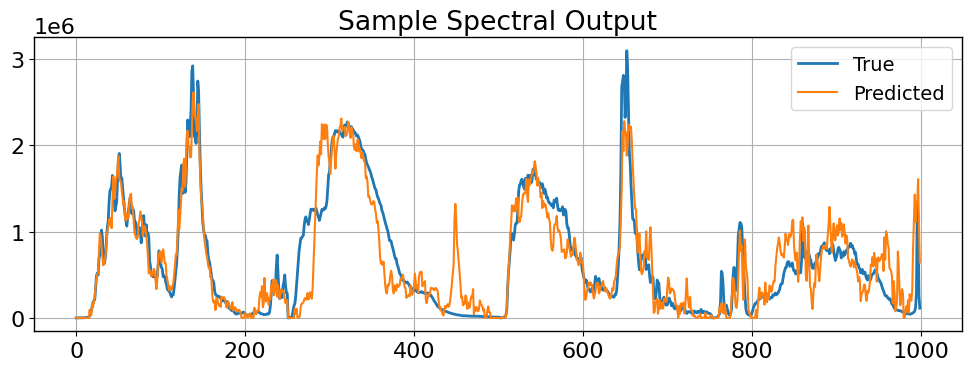

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(y_true_test[:1000], label='True', linewidth=2)
plt.plot(y_pred_test[:1000], label='Predicted', linewidth=1.5)
plt.title("Sample Spectral Output")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [100]:
import numpy as np

errors = np.abs(y_true_test - y_pred_test)
worst_idx = np.argmax(errors)
print("Worst error at index:", worst_idx)
print("True:", y_true_test[worst_idx])
print("Pred:", y_pred_test[worst_idx])

Worst error at index: 7962
True: 3001637.1056538667
Pred: 851183.7339169293
